# Common Dataset/Data Module

Classes to handle the combined dataset and data modules were developed based on the existing `FTW` classes in `ftw-baselines` and `torchgeo` and the corresponding data modules. Several adaptations of these were made:

- The classes use a catalog file rather than reading into directories
- Additional augmentations were added to those used in `ftw-baselines`: 
    - Kornia-based photometric augmentations that go part way towards the [brightness shift](https://github.com/agroimpacts/fieldmapper/blob/27fdea4a2cd358ffade4fec7f8cb59c801f2fd05/src/datatorch.py#L326-L337) that was found by [Khallaghi et al, 2025](https://www.mdpi.com/2072-4292/17/3/474) to to be important for generalizing between years. 
    - SatSlideMix from `torchgeo`. 
- Additional image normalization approaches. FTW normalizes bands with a mean of 0 and std of 3000 for all images. For Mapping Africa models, we typically apply across band min-max with some tail clipping.

## Test of data module

With subset of the combined catalog.

In [1]:
import pandas as pd
import numpy as np
from ftw_ma import *

Create a small catalog

In [ ]:
toycat = (pd.read_csv("../data/ftw-mappingafrica-combined-catalog.csv")
          .sample(96, random_state=42)
          .reset_index(drop=True))
toycat.to_csv("../data/toycat.csv", index=False)
toycat.head(n=5)

,name,dataset,version,country,x,y,fld_prop,nonfld_prop,null_prop,window_a,window_b,mask,split
0,g15_00070_18,ftw,1.0.0,estonia,26.643397,58.062194,0.406845,0.593155,0.0,ftw/estonia/s2_images/window_a/g15_00070_18.tif,ftw/estonia/s2_images/window_b/g15_00070_18.tif,ftw/estonia/label_masks/semantic_3class/g15_00...,train
1,SD4949438,mappingafrica,v2.0.0,SD,32.086500,12.837500,0.998406,0.001594,0.0,mappingafrica-256/images/SD4949438_2020-02.tif,NaN,mappingafrica-256/labels/SD4949438_20927_2020-...,test
2,g31_00030_10,ftw,1.0.0,latvia,27.383486,56.589763,0.060104,0.939896,0.0,ftw/latvia/s2_images/window_a/g31_00030_10.tif,ftw/latvia/s2_images/window_b/g31_00030_10.tif,ftw/latvia/label_masks/semantic_3class/g31_000...,train
3,BF0769560,mappingafrica,v2.0.0,BF,0.786500,11.077500,0.549805,0.450195,0.0,mappingafrica-256/images/BF0769560_2020-02.tif,NaN,mappingafrica-256/labels/BF0769560_36275_2020-...,test
4,g11_00118_12,ftw,1.0.0,lithuania,23.081058,54.605171,0.709503,0.290497,0.0,ftw/lithuania/s2_images/window_a/g11_00118_12.tif,ftw/lithuania/s2_images/window_b/g11_00118_12.tif,ftw/lithuania/label_masks/semantic_3class/g11_...,train


Test with different normalization approaches and augmentations.

In [21]:
kwargs = {
    "catalog": "../data/toycat2.csv",
    "data_dir": "/Users/LEstes/data/labels/cropland/",
    "img_clip_val": 0, 
    # "normalization_strategy": "z_value",
    "normalization_strategy": "min_max",
    # "normalization_stat_procedure": "lpb"
    "normalization_stat_procedure": "lab"
    # "normalization_stat_procedure": "gab",
    # "normalization_stat_procedure": "gpb",
    # "global_stats": {"mean": [0,0,0,0], "std": [3000,3000,3000,3000]},
    # "global_stats": {"mean": 0, "std": 3000},
    # "nodata": [41303, 65535],  # nodata values to ignore in the imagery
}
dm = FTWMapAfricaDataModule(
    temporal_options = "windowA",
    aug_list = ["rotation", "hflip", "vflip", "sharpness", 
                # "gaussian_noise", 
                "gamma", 
                "brightness", 
                "contrast", 
                "rescale", 
                "satslidemix"],
    # aug_list = ["rotation", "hflip", "vflip", "sharpness"],  # FTW augs
    # aug_list = ["rotation", "hflip", "vflip"],  # FTW augs
    # aug_list=["rotation"],  # augmentations to apply
    # aug_list=["hflip"],
    # aug_list=["sharpness"],
    # aug_list=["gaussian_noise"],  # gives an error sometimes
    # aug_list=["gamma"],  # check this throws some bad values also (nans)
    # aug_list=["brightness"],
    # aug_list=["contrast"],
    # aug_list=["rescale"],
    # aug_list=["satslidemix"],
    **kwargs
)
dm.setup("fit")

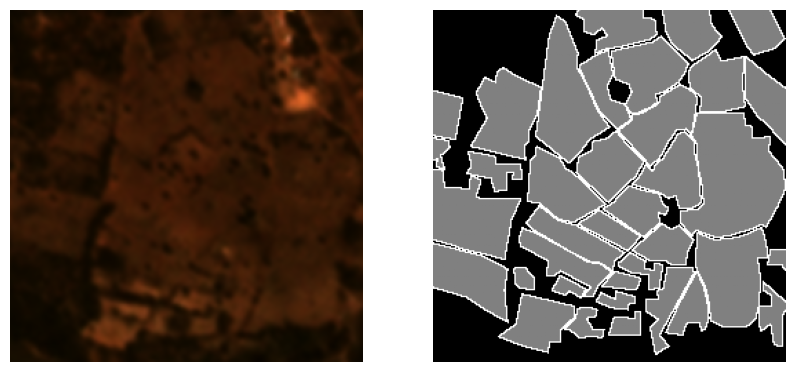

tensor(1.) tensor(0.)


In [35]:
sample = dm.train_dataset[12] 
fig = dm.train_dataset.plot(sample)  # Plot the augmented sample
plt.show()
print(sample["image"].max(), sample["image"].min())

Band distributions.

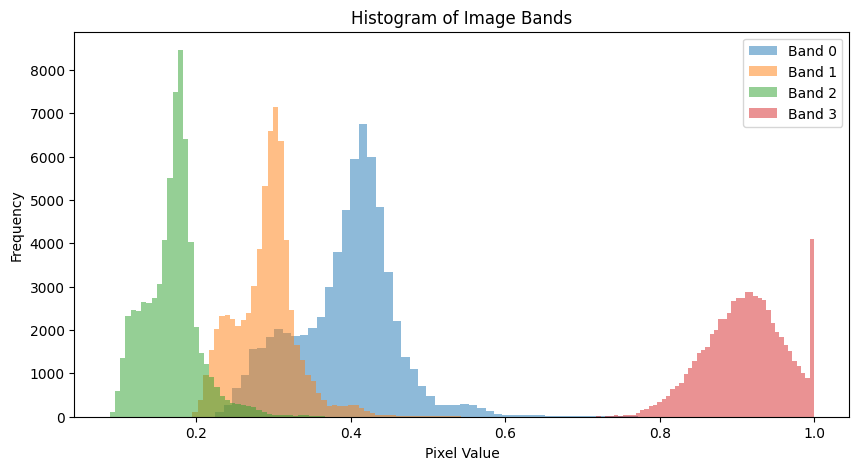

In [10]:
img_np = sample["image"].numpy().transpose(1, 2, 0)  # (H, W, C)
plt.figure(figsize=(10, 5))
for i in range(img_np.shape[2]):
    plt.hist(img_np[..., i].ravel(), bins=50, alpha=0.5, label=f'Band {i}')
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram of Image Bands")
plt.show()

The augmentations in these sequences seem to work, but `RandomGaussianNoise` gives negative values at times, so for now should be dropped from the augmentation list until a clamping procedure can be added. 

Also note z-value normalization does not work with global stats for "gab" with 0s for means of all bands with 3000 for stds (FTW values). Use "gpb" for this. 


A quick look at the validation loader.

In [11]:
dm.setup("validate")

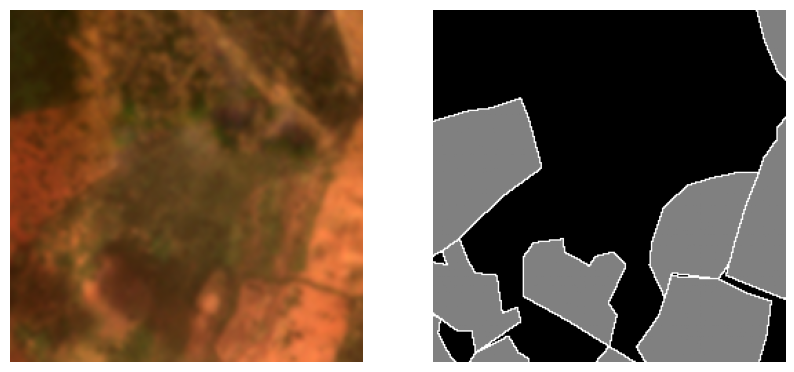

tensor(1.4510) tensor(0.1107)


In [13]:
sample = dm.val_dataset[1]
fig = dm.val_dataset.plot(sample)  # Plot the augmented sample
plt.show()
print(sample["image"].max(), sample["image"].min())